# 패키지 불러오기

In [20]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Okt
import pandas as pd
import enum
import os
import re

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [22]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [23]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [24]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [25]:
# Show length
print(len(index_inputs),  len(index_outputs), len(index_targets))

20 20 20


## 모델 만들기에 필요한 값 선언

In [26]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 3
#BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

# 모델 

## 인코더

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

#     def initialize_hidden_state(self, batch_sz=None):
#         if batch_sz is None:
#             batch_sz = self.batch_sz
#         return tf.zeros((batch_sz, self.enc_units))
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

## 어텐션

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 디코더

In [29]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [30]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

## 시퀀스 투 스퀀스 모델

In [31]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [32]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
model.run_eagerly = True

## 학습 진행

In [33]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

# history = model.fit([index_inputs, index_outputs], index_targets,
#                     batch_size=BATCH_SIZE, epochs=EPOCH,
#                     validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])
# history = model.fit(dataset, epochs=EPOCH, steps_per_epoch=steps_per_epoch)
#history = model.fit(dataset, epochs=EPOCH, steps_per_epoch=steps_per_epoch)
# history = model.fit(train_dataset, epochs=EPOCH, steps_per_epoch=steps_per_epochs, validation_data=eval_dataset, 
#                    callbacks=[earlystop_callback, cp_callback])
# history = model.fit(train_dataset, epochs=EPOCH, validation_data=eval_dataset, callbacks=[cp_callback])
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Train on 18 samples, validate on 2 samples
Epoch 1/30
15/18 [========================>.....] - ETA: 1s - loss: 0.8116 - accuracy: 0.8289
Epoch 00001: val_accuracy improved from -inf to 0.85200, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 7s 381ms/sample - loss: 0.8328 - accuracy: 0.8322 - val_loss: 0.6671 - val_accuracy: 0.8520
Epoch 2/30
15/18 [========================>.....] - ETA: 1s - loss: 0.7536 - accuracy: 0.8513
Epoch 00002: val_accuracy improved from 0.85200 to 0.85500, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 7s 367ms/sample - loss: 0.7434 - accuracy: 0.8517 - val_loss: 0.6296 - val_accuracy: 0.8550
Epoch 3/30
15/18 [========================>.....] - ETA: 0s - loss: 0.7074 - accuracy: 0.8533
Epoch 00003: val_accuracy improved from 0.85500 to 0.85600, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 7s 364ms/sample - loss: 0.6798 - accuracy

15/18 [========================>.....] - ETA: 0s - loss: 0.0696 - accuracy: 0.9191
Epoch 00025: val_accuracy improved from 0.91800 to 0.92040, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 6s 361ms/sample - loss: 0.0727 - accuracy: 0.9193 - val_loss: 0.1350 - val_accuracy: 0.9204
Epoch 26/30
15/18 [========================>.....] - ETA: 0s - loss: 0.0571 - accuracy: 0.9215
Epoch 00026: val_accuracy improved from 0.92040 to 0.92277, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 6s 355ms/sample - loss: 0.0569 - accuracy: 0.9217 - val_loss: 0.1817 - val_accuracy: 0.9228
Epoch 27/30
15/18 [========================>.....] - ETA: 1s - loss: 0.0377 - accuracy: 0.9239
Epoch 00027: val_accuracy improved from 0.92277 to 0.92496, saving model to ./data_out/seq2seq_kor/weights.h5
18/18 [==============================] - 7s 368ms/sample - loss: 0.0549 - accuracy: 0.9241 - val_loss: 0.2770 - val_accuracy: 0.925

## 결과 플롯

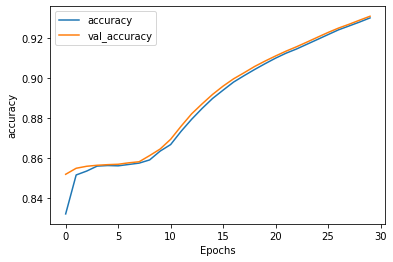

In [34]:
plot_graphs(history, 'accuracy')

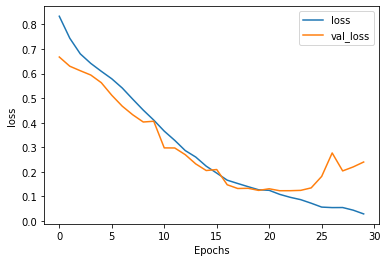

In [35]:
plot_graphs(history, 'loss')

### 결과 확인

In [36]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [37]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[105  96  14   7]
평소에 필요한 것 같아요
